In [1]:
import os
import numpy as np
import pandas as pd
import cantera as ct
from time import time
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
# Directories
DIR     = os.getcwd()

Reader Functions

In [3]:
def reader(csv:str):
    data = np.loadtxt(csv, delimiter=',', unpack=True)
    return data

def func_interpolate(xData, yData, kind='linear'):
    return interp1d(xData, yData, kind=kind)

Fix data variation where digitization was performed.

In [10]:
x2, y2 = reader(os.path.join(DIR, "fig5-35.csv"))
f2 = func_interpolate(x2, y2)

# Data normalization (data was corrupted during digitization).
y_max = max(y2)
y2 = y2 - (y_max - 0.25)


temp = 0.0265 * (1 - 0.0265)
x_at_target_eta = np.interp(temp, y2, x2)

# Assunme a constant radius
r = 2.5/1000
x2_new = r / y2
x_max_val = r / 0.085
print(x_max_val)
y2_new = (1 - np.sqrt(1 - 4 * y2)) / 2


x_at_target_spatial = np.interp(0.0265, y2_new, x2_new)
y_at_target_mass_fraction = np.interp(x_max_val, x2_new, y2_new)
print(y_at_target_mass_fraction)

# temporary assumption
L_premixer = 10.04/1000# m
L_eta_premixer = r / L_premixer

var_at_premixer_exit = np.interp(L_eta_premixer, x2, y2)
print(var_at_premixer_exit)

0.029411764705882353
0.0939151639958634
0.05885974679217476


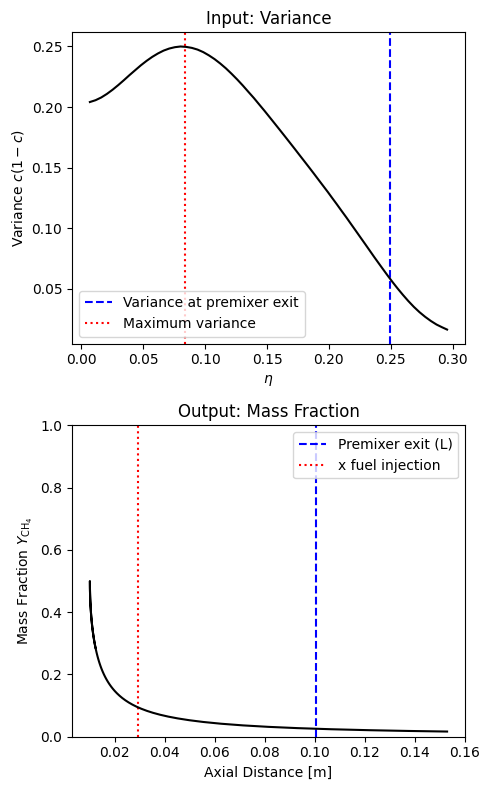

In [5]:
plt.figure(figsize=(5, 8))
plt.subplot(2, 1, 1)
plt.axvline(x=L_eta_premixer, color='blue', linestyle='--', label='Variance at premixer exit')
plt.axvline(x=0.084, color='red', linestyle=':', label='Maximum variance')
plt.plot(x2, y2, color='black')
plt.title("Input: Variance")
plt.legend()
plt.xlabel(r"$\eta$")
plt.ylabel(r"Variance $c(1-c)$")

plt.subplot(2, 1, 2)
plt.axvline(x=L_premixer*10, color='blue', linestyle='--', label='Premixer exit (L)')
plt.axvline(x=x_max_val, color='red', linestyle=':', label='x fuel injection')
plt.plot(x2_new, y2_new, color='black')
plt.title("Output: Mass Fraction")
plt.xlabel("Axial Distance [m]")
plt.ylabel(r"Mass Fraction $Y_{\text{CH}_4}$")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.savefig("scalar_variance.pdf")
plt.show()



## Look into stream mixing.

In [6]:
mech = 'aramco3.yaml'
fuel:dict       = {"CH4":1}
oxidizer:dict   = {"O2":0.21 ,"N2":0.79}

gas_a = ct.Solution("air.yaml")
gas_a.TP = 750, 24 * ct.one_atm
rho_a = gas_a.density

gas_b = ct.Solution(mech)
gas_b.TPX = 340, 24 * ct.one_atm, fuel
rho_b = gas_b.density

res_a = ct.Reservoir(gas_a, name='Air Reservoir')
res_b = ct.Reservoir(gas_b, name='Fuel Reservoir')
downstream = ct.Reservoir(gas_a, name='Outlet Reservoir')

gas_b.TPX = 300, ct.one_atm, 'O2:0.21, N2:0.79'
mixer = ct.IdealGasReactor(gas_b, name='Mixer')

mfc1 = ct.MassFlowController(res_a, mixer, mdot=61, name="Air Inlet")
mfc2 = ct.MassFlowController(res_b, mixer, mdot=1.66, name="Fuel Inlet")

outlet = ct.Valve(mixer, downstream, K=10.0, name="Valve")

sim = ct.ReactorNet([mixer])
sim.advance_to_steady_state()

print(mixer.thermo.report())



  gas:

       temperature   721.15 K
          pressure   2.4318e+06 Pa
           density   11.504 kg/m^3
  mean mol. weight   28.365 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        3.3591e+05         9.528e+06  J
   internal energy        1.2452e+05         3.532e+06  J
           entropy            7063.6        2.0035e+05  J/K
    Gibbs function        -4.758e+06       -1.3496e+08  J
 heat capacity c_p              1149             32590  J/K
 heat capacity c_v            855.84             24275  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                AR          0.013425         0.0095316            -20.84
                N2           0.73428           0.74347           -21.213
                H2        1.4743e-13        2.0743e-12           -40.482

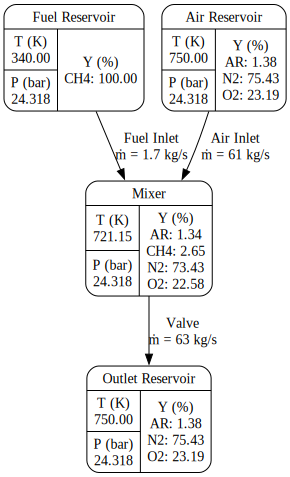

In [7]:
sim.draw(print_state=True, species="Y")

In [8]:
gas_mixed = ct.Solution('aramco3.yaml')

In [9]:
gas_mixed.TP = 750, 24 * ct.one_atm
gas_mixed.set_equivalence_ratio(phi=0.47, fuel=fuel, oxidizer=oxidizer)

print(gas_mixed.report())


  gas:

       temperature   750 K
          pressure   2.4318e+06 Pa
           density   11.016 kg/m^3
  mean mol. weight   28.248 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        3.7165e+05        1.0498e+07  J
   internal energy        1.5089e+05        4.2625e+06  J
           entropy            7138.4        2.0165e+05  J/K
    Gibbs function       -4.9821e+06       -1.4074e+08  J
 heat capacity c_p            1166.9             32963  J/K
 heat capacity c_v            872.58             24649  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                N2            0.7466           0.75285           -21.284
                O2           0.22669           0.20012           -24.275
               CH4          0.026709          0.047029           -35.886
  